In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../../xtrack/examples/fcc_ee_solenoid/fccee_t_with_sol_corrected.json')

line.vars['voltca1'] = 75      # RF on
line.vars['voltca2'] = 349.77
line.vars['on_sol_ip.1'] = 1    # Solenoid on
line.vars['on_corr_ip.1'] = 1   # Solenoid correction on 

# Twiss with no radiation
tw_rad_off = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/116828 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [4]:
line.configure_radiation(model='mean') # Radiation without quantun fluctuations

In [8]:
tw_rad_on = line.twiss(start='ip.4', end='ip.4.l', init=tw_rad_off)

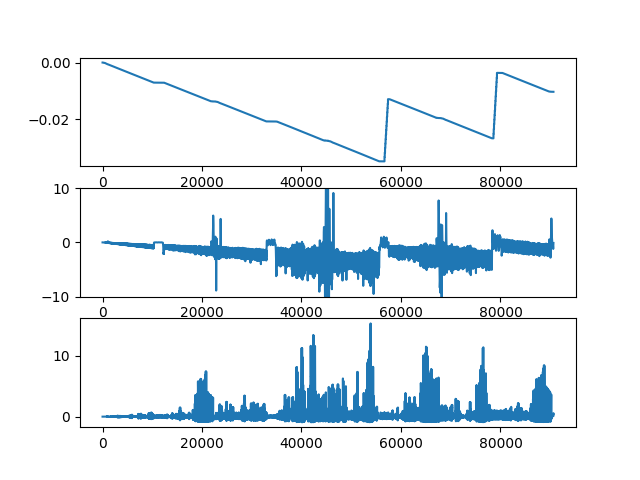

In [10]:
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(tw_rad_on.s, tw_rad_on.delta)
ax2 = plt.subplot(3,1,2, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.x*1e3)
plt.ylim(-10, 10)
ax2 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.betx / tw_rad_off.betx - 1)

In [11]:
line.compensate_radiation_energy_loss()

Compensating energy loss.
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.
Found suitable prebuilt kernel `only_xtrack_with_synrad`.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Share energy loss among cavities (repeat until energy loss is zero)
Found suitable prebuilt kernel `only_xtrack_taper`.
Energy loss: 9115673866.355 eV             
Energy loss: 447222577.862 eV             
Energy loss: 23200141.587 eV             
Energy loss: 1206826.036 eV             
Energy loss: 62785.636 eV             
Energy loss: 3266.476 eV             
Energy loss: 169.941 eV             
Energy loss: 8.842 eV             

  - Set delta_taper
  - Restore cavity voltage and frequency. Set cavity lag


In [12]:
tw_compens_on = line.twiss()

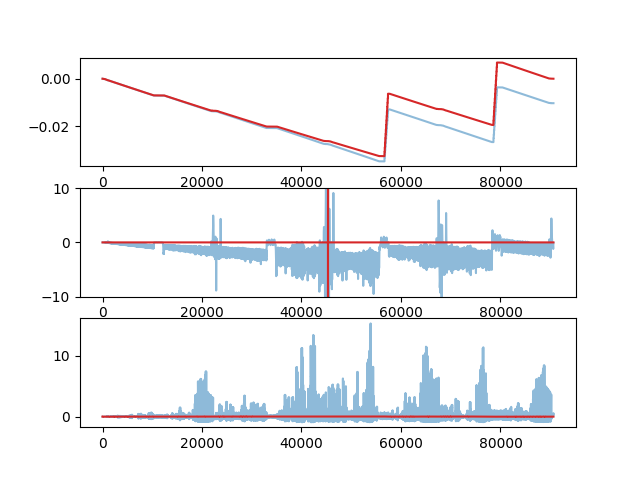

In [20]:
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(tw_rad_on.s, tw_rad_on.delta, alpha=0.5)
plt.plot(tw_rad_on.s, tw_compens_on.delta, color='C3')
ax2 = plt.subplot(3,1,2, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.x*1e3, alpha=0.5)
plt.plot(tw_rad_on.s, tw_compens_on.x*1e3, color='C3')
plt.ylim(-10, 10)
ax2 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.betx / tw_rad_off.betx - 1, alpha=0.5)
plt.plot(tw_rad_on.s, tw_compens_on.betx / tw_rad_off.betx - 1, color='C3')

In [26]:
tw = line.twiss(eneloss_and_damping=True, search_for_t_rev=True)

In [24]:
1 / tw.damping_constants_turns # Damping times

array([37.57708587, 37.5767601 , 18.78827113])

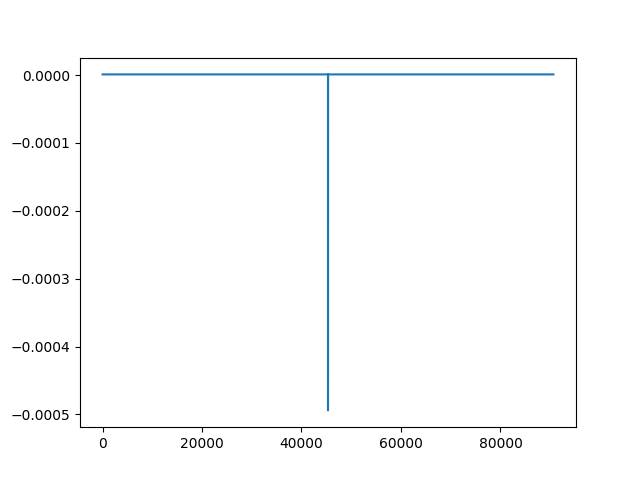

In [30]:
plt.figure()
plt.plot(tw.s, tw.zeta)

In [ ]:
bs = tw_rad.get_beam_covariance(gemitt_x=tw_rad.eq_gemitt_x, gemitt_y=tw_rad.eq_gemitt_y, gemitt_zeta=tw_rad.eq_gemitt_zeta)

In [ ]:
1/tw.damping_constants_turns

In [ ]:
tw.partition_numbers

In [ ]:
tw.partition_numbers.sum()

In [ ]:
tw.c_minus

In [ ]:
tw.eq_gemitt_x

In [ ]:
plt.figure()
plt.plot(tw.s, tw.dy)